In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True
def my_obj(preds, train_data):
    labels = train_deata.get_label()

In [4]:
train = pd.read_csv('../data/public_raw.train.csv')
test = pd.read_csv('../data/public_raw.test.csv')

train_len = train.shape[0]

train['is_train']=1
test['is_train']=0

df = pd.concat([train, test],sort=False)

In [5]:
df.rename(index=str, columns=rep_cols, inplace=True)

df.sort_values(by=['ID'],ascending=True, inplace=True)

df.reset_index(drop=True, inplace=True)

In [6]:
# #特征类型一：利用发电量关于时间的连续性，利用前后时刻的发电量对当前时刻预测

# next_one = []
# prev_one = []
# # next_id = []
# # prev_id = []

# second_next_one = []
# second_prev_one = []

# df_len = df.shape[0]

# i_y =df.columns.get_loc("y")

# def get_prev_nn_index(cur_i):
#     prev_i = cur_i-1
#     while(prev_i>=0 and pd.isnull(df.iat[prev_i,i_y])):
#         prev_i-=1
#     return prev_i

# def get_next_nn_index(cur_i):
#     prev_i = cur_i+1
#     while(prev_i<df_len and pd.isnull(df.iat[prev_i,i_y])):
#         prev_i+=1
#     return prev_i

# for i in range(df_len):
#     f_pre_i=get_prev_nn_index(i)
#     if(f_pre_i)<0:
#         prev_one.append(np.nan)
# #         prev_id.append(0)
#     else:
#         prev_one.append(df.iat[f_pre_i,i_y])
# #         prev_id.append(f_pre_i)
        
#     s_pre_i=get_prev_nn_index(f_pre_i)
#     if (s_pre_i)<0:
#         second_prev_one.append(np.nan)
#     else:
#         second_prev_one.append(df.iat[s_pre_i,i_y])
    
#     f_next_i=get_next_nn_index(i)
#     if(f_next_i<df_len):
#         next_one.append(df.iat[f_next_i,i_y])
# #         next_id.append(f_next_i)
#     else:
#         next_one.append(np.nan)
# #         next_id.append(df_len)
    
#     s_next_i=get_next_nn_index(f_next_i)
#     if(s_next_i<df_len):
#         second_next_one.append(df.iat[s_next_i,i_y])
#     else:
#         second_next_one.append(np.nan)
        
        
        
# df['next_valid_y'] = next_one
# df['prev_valid_y'] = prev_one
# #前后两个有效发电量及均值
# df['2_avg_valid_y'] = np.nanmean([df['next_valid_y'], df['prev_valid_y']],axis=0)
# # df['second_prev_valid_y'] = second_prev_one
# # df['second_next_valid_y'] = second_next_one
# #前后四个有效发电量及均值
# # df['4_avg_valid_y'] = np.nanmean([df['second_next_valid_y'],df['next_valid_y'], df['prev_valid_y'],df['second_prev_valid_y']],axis=0)




# rolling_mask_two = [-i for i in range(1,2)]+[i for i in range(1,2)]
# rolling_mask_four = [-i for i in range(1,3)]+[i for i in range(1,3)]
# rolling_mask_six = [-i for i in range(1,4)]+[i for i in range(1,4)]
# rolling_mask_eight = [-i for i in range(1,5)]+[i for i in range(1,5)]
# #前后六个发电量（ID顺序，包括NaN)的均值
# # df['6_avg_rolling_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_six],axis=0)
# #前后八个发电量（ID顺序，包括NaN)的均值
# df['8_avg_rolling_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_eight],axis=0)


# #保存feature
# y_predictive_feat = df[['ID']]
# y_predictive_feat['next_valid_y'] = df['next_valid_y']
# y_predictive_feat['prev_valid_y'] = df['prev_valid_y']
# y_predictive_feat['2_avg_valid_y'] = df['2_avg_valid_y']
# y_predictive_feat['8_avg_rolling_y'] = df['8_avg_rolling_y']

# y_predictive_feat.to_pickle('../feature/y_predictive_feat.pkl')

In [7]:
y_predictive_feat = pd.read_pickle('../feature/y_predictive_feat.pkl')

df = df.merge(y_predictive_feat, on='ID', how='left')

df.head()

,ID,board_t,env_t,light_strength,efficiency,efficiency_A,efficiency_B,efficiency_C,V_A,V_B,...,P_C,P_avg,wind_speed,wind_direction,y,is_train,next_valid_y,prev_valid_y,2_avg_valid_y,8_avg_rolling_y
0,1,0.01,0.1,1,0.00,0.00,0.00,0.00,0,0,...,0.00,0.00,0.1,1,NaN,0,1.437752,NaN,1.437752,1.702038
1,9,-19.33,-17.5,13,198.32,259.11,42.17,293.66,722,705,...,1031.03,696.27,0.3,273,NaN,0,1.437752,NaN,1.437752,1.702038
2,10,-19.14,-17.4,34,80.55,106.32,16.98,118.36,729,709,...,1087.50,740.11,0.6,272,1.437752,1,1.692575,NaN,1.692575,2.013006
3,11,-18.73,-17.3,30,99.90,139.00,21.20,139.51,728,717,...,1132.56,811.01,0.8,275,1.692575,1,1.975787,1.437752,1.706770,2.079071
4,12,-17.54,-17.0,41,82.48,114.86,14.91,117.66,731,722,...,1310.40,918.57,1.1,283,1.975787,1,2.370656,1.692575,2.031615,2.162558


In [17]:
#特征类型二：利用电流、电压、功率（电流电压乘积）关于时间的连续性，利用前后时刻的测量量刻画评估异常测量量的baseline
#刻画异常程度 abs(value_m-value_avg)/value_avg
rolling_mask_six = [-i for i in range(1,4)]+[i for i in range(1,4)]
rolling_mask_eight = [-i for i in range(1,5)]+[i for i in range(1,5)]

# df['rolling_eight_VA'] = np.nanmean([df['V_A'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_eight_VB'] = np.nanmean([df['V_B'].shift(i) for i in rolling_mask_eight],axis=0)
# df['rolling_eight_VC'] = np.nanmean([df['V_C'].shift(i) for i in rolling_mask_eight],axis=0)
# df['6_avg_rolling_VA'] = np.nanmean([df['V_A'].shift(i) for i in rolling_mask_six],axis=0)
# df['6_avg_rolling_VB'] = np.nanmean([df['V_B'].shift(i) for i in rolling_mask_six],axis=0)
# df['6_avg_rolling_VC'] = np.nanmean([df['V_C'].shift(i) for i in rolling_mask_six],axis=0)
# df['6_avg_rolling_VA'] = np.nanmean([df['V_A'].shift(i) for i in rolling_mask_six],axis=0)
# df['6_avg_rolling_VB'] = np.nanmean([df['V_B'].shift(i) for i in rolling_mask_six],axis=0)
# df['6_avg_rolling_VC'] = np.nanmean([df['V_C'].shift(i) for i in rolling_mask_six],axis=0)
# df['6_avg_rolling_PA'] = np.nanmean([df['V_A'].shift(i) for i in rolling_mask_six],axis=0)
# df['6_avg_rolling_VB'] = np.nanmean([df['V_B'].shift(i) for i in rolling_mask_six],axis=0)
# df['6_avg_rolling_VC'] = np.nanmean([df['V_C'].shift(i) for i in rolling_mask_six],axis=0)

# for c in ['V_A','V_B','V_C','I_A','I_B','I_C','P_A','P_B','P_C']:
#     if c in ['V_A','V_B','V_C','I_A','I_B','I_C']:
#         df['6_avg_rolling_'+c] = np.nanmean([df[c].shift(i) for i in rolling_mask_six],axis=0)
#     if c in ['P_A','P_B','P_C']:
#         x = c[-1:]
#         df['6_avg_rolling_'+c] = df['6_avg_rolling_V_'+x]*df['6_avg_rolling_I_'+x]

# df['6_avg_rolling_P_avg'] =1/3*(df['6_avg_rolling_P_A']+df['6_avg_rolling_P_B']+df['6_avg_rolling_P_C'])

for c in ['V_A','V_B','V_C','I_A','I_B','I_C','P_A','P_B','P_C']:
    if c in ['V_A','V_B','V_C','I_A','I_B','I_C']:
        df['8_avg_rolling_'+c] = np.nanmean([df[c].shift(i) for i in rolling_mask_eight],axis=0)
    if c in ['P_A','P_B','P_C']:
        x = c[-1:]
        df['8_avg_rolling_'+c] = df['8_avg_rolling_V_'+x]*df['8_avg_rolling_I_'+x]

df['8_avg_rolling_P_avg'] =1/3*(df['8_avg_rolling_P_A']+df['8_avg_rolling_P_B']+df['8_avg_rolling_P_C'])
    
for c in ['V_A','V_B','V_C','I_A','I_B','I_C','P_A','P_B','P_C','P_avg']:
    df['diff_'+c] = np.abs(df[c]-df['8_avg_rolling_'+c])
    df['diff_std_ratio_'+c] = df['diff_'+c].rolling(10,center=True).std()
    
    df['value_diff_'+c] = df[c].shift(1)-df[c]
    df['value_diff_order2_'+c] = df['value_diff_'+c].shift(1) - df['value_diff_'+c]

# df['6_avg_rolling_P_A'] = df['6_avg_rolling_V_A']*df['6_avg_rolling_I_A']
# df['6_avg_rolling_P_B'] = df['6_avg_rolling_V_B']*df['6_avg_rolling_I_B']
# df['6_avg_rolling_P_C'] = df['6_avg_rolling_V_C']*df['6_avg_rolling_I_C']



In [9]:
df.head(50)

,ID,board_t,env_t,light_strength,efficiency,efficiency_A,efficiency_B,efficiency_C,V_A,V_B,...,value_diff_P_A,diff_P_B,diff_std_ratio_P_B,value_diff_P_B,diff_P_C,diff_std_ratio_P_C,value_diff_P_C,diff_P_avg,diff_std_ratio_P_avg,value_diff_P_avg
0,1,0.01,0.1,1,0.00,0.00,0.00,0.00,0,0,...,NaN,160.481250,NaN,NaN,1140.532500,NaN,NaN,791.358750,NaN,NaN
1,9,-19.33,-17.5,13,198.32,259.11,42.17,293.66,722,705,...,-909.72,36.965600,NaN,-148.05,230.630000,NaN,-1031.03,140.802000,NaN,-696.27
2,10,-19.14,-17.4,34,80.55,106.32,16.98,118.36,729,709,...,-67.14,29.473889,NaN,-7.93,190.048889,NaN,-56.47,115.342778,NaN,-43.84
3,11,-18.73,-17.3,30,99.90,139.00,21.20,139.51,728,717,...,-151.54,34.080204,NaN,-16.10,142.053061,NaN,-45.06,127.892517,NaN,-70.90
4,12,-17.54,-17.0,41,82.48,114.86,14.91,117.66,731,722,...,-150.85,16.277500,NaN,6.02,256.507500,NaN,-177.84,178.840625,NaN,-107.56
5,13,-16.68,-16.6,50,73.59,97.95,14.70,108.12,729,715,...,-54.82,212.900000,234.595670,-34.14,62.103125,337.322675,-162.18,47.839167,211.310790,-83.71
6,14,-15.43,-16.6,53,73.98,101.72,15.55,104.67,730,727,...,-140.53,384.297500,15866.581875,-25.17,8.560000,95.613686,-44.76,107.559167,7833.032099,-70.16
7,15,-14.60,-16.3,65,64.62,86.86,13.09,93.92,727,729,...,-73.91,589.559062,21164.224505,-7.91,73.686563,101.383751,-157.06,163.660833,10501.357759,-79.62
8,16,-14.10,-16.2,76,61.97,77.59,25.80,82.53,733,728,...,-71.42,463.846875,24254.348436,-305.44,18.463750,106.020807,-48.72,146.601042,12100.321097,-141.86
9,17,-13.27,-16.2,83,75.36,73.55,73.36,79.16,728,723,...,-61.75,584.082031,25905.343051,-1138.64,28.005312,106.695383,-86.88,197.449844,13006.453084,-429.09


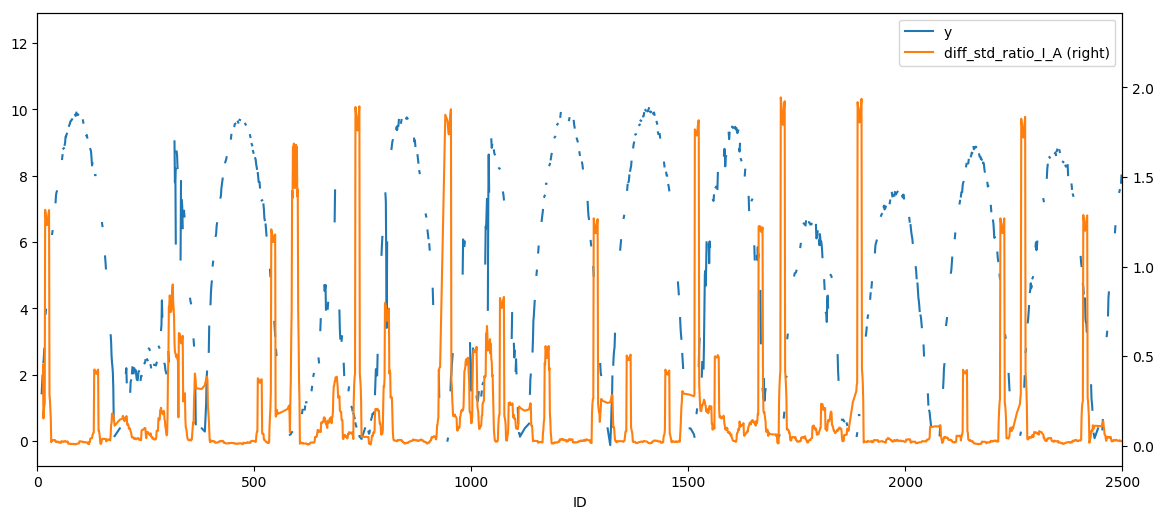

In [10]:
figure(figsize=(14,6),dpi=100)
ax = plt.gca()

df.plot(x='ID',xlim=(0,2500),y='y',ax=ax)
df.plot(x='ID',y='diff_std_ratio_I_A',secondary_y=True,ax=ax)

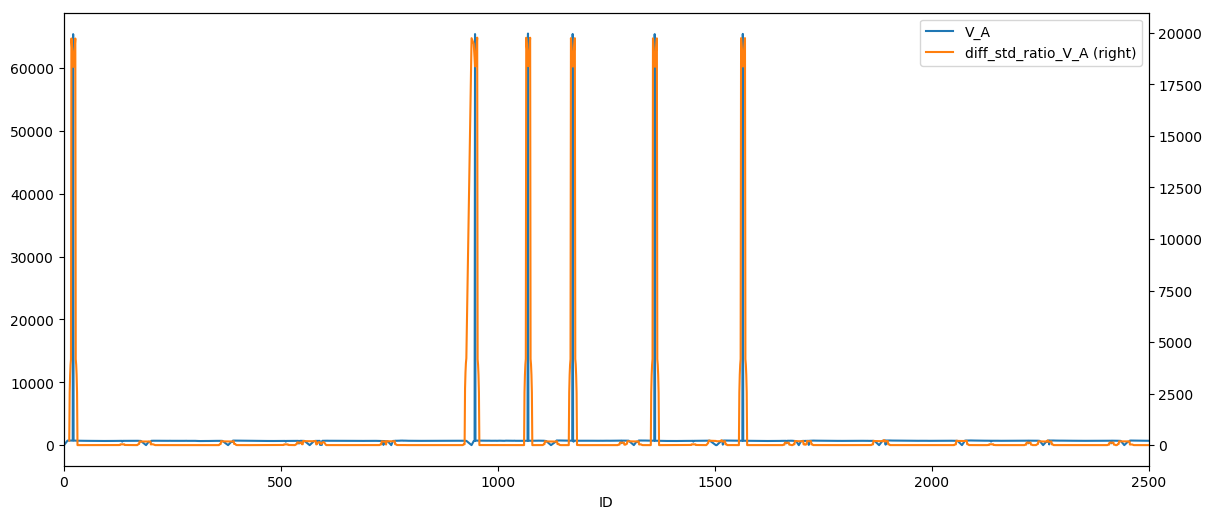

In [11]:
figure(figsize=(14,6),dpi=100)
ax = plt.gca()

df.plot(x='ID',xlim=(0,2500),y='V_A',ax=ax)
df.plot(x='ID',y='diff_std_ratio_V_A',secondary_y=True,ax=ax)

In [21]:
df.head()

,ID,board_t,env_t,light_strength,efficiency,efficiency_A,efficiency_B,efficiency_C,V_A,V_B,...,value_diff_order2_V_A,value_diff_order2_V_B,value_diff_order2_V_C,value_diff_order2_I_A,value_diff_order2_I_B,value_diff_order2_I_C,value_diff_order2_P_A,value_diff_order2_P_B,value_diff_order2_P_C,value_diff_order2_P_avg
0,1,0.01,0.1,1,0.00,0.00,0.00,0.00,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,-19.33,-17.5,13,198.32,259.11,42.17,293.66,722,705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,-19.14,-17.4,34,80.55,106.32,16.98,118.36,729,709,...,-715.0,-701.0,-717.0,-1.18,-0.20,-1.36,-842.58,-140.12,-974.56,-652.43
3,11,-18.73,-17.3,30,99.90,139.00,21.20,139.51,728,717,...,-8.0,4.0,-3.0,0.13,0.01,-0.01,84.40,8.17,-11.41,27.06
4,12,-17.54,-17.0,41,82.48,114.86,14.91,117.66,731,722,...,4.0,-3.0,-7.0,-0.01,-0.03,0.20,-0.69,-22.12,132.78,36.66


In [22]:
#train和test拆分
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [37]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

In [40]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0,
#     'lambda_l1':0.1,
#     'lambda_l2':0.1,
#     'min_child_samples':20
}

test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]
        tst = test.copy()

#         grouper = ['bin_ls','bin_env_t','bin_board_t']
#         x = tra.groupby(grouper)['y'].agg({'target_encoding_mean':'mean',
#                                            'target_encoding_max':'max',
#                                            'target_encoding_min':'min',
#                                            'target_encoding_median':'median',
#                                            'target_encoding_var':'var',
#                                            'target_encoding_count':'count'}).reset_index()
#         tra = tra.merge(x, on=grouper, how='left')
#         val = val.merge(x, on= grouper , how ='left')
#         tst = tst.merge(x, on=grouper, how='left')
        predictor = [c for c in tra.columns.tolist() if c not in['y','is_train']]
#         predictor = [c for c in tra.columns.tolist() if c in['P_A','P_B','P_C','P_avg_corrected','I_A','light_strength','board_t','avg_value','wind_direction','wind_speed','rolling_six_y']]
#         tra.fillna(-99999, inplace=True)
#         val.fillna(-99999, inplace=True)
#         model_extree = RandomForestRegressor(n_estimators=1000,max_depth=10,max_features=0.7,n_jobs=-1,verbose=1)
#         model_extree.fit(tra[predictor], tra['y'])
#         val_preds[idx][val_idx] = model_extree.predict(val[predictor])
#         test_predicts.append(model.predict(tst[predictor]))

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(tst[predictor]))

print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[356]	valid's l2: 0.0598254	valid's score: 0.803476
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.019117	valid's score: 0.878531
[1000]	valid's l2: 0.018742	valid's score: 0.879584
Early stopping, best iteration is:
[911]	valid's l2: 0.0187155	valid's score: 0.879659
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[148]	valid's l2: 0.0133551	valid's score: 0.896407
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0421512	valid's score: 0.829664
Early stopping, best iteration is:
[830]	valid's l2: 0.0419846	valid's score: 0.829943
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[354]	valid's l2: 0.017487	valid's score: 0.883206
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0610561	valid

In [39]:
rf_val_preds = val_preds.copy()

In [41]:
lgb_val_preds = val_preds.copy()

In [43]:
np.corrcoef(np.mean(rf_val_preds,axis=0), np.mean(lgb_val_preds,axis=0))

array([[1.        , 0.99957735],
       [0.99957735, 1.        ]])

In [24]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False)

I_A                      144369.951786
P_A                      127313.568652
I_C                       54958.351497
P_avg                     47568.797047
2_avg_valid_y             27464.302183
P_B                       14467.337032
P_C                       13151.242136
I_B                        7115.814767
8_avg_rolling_y            5457.674852
8_avg_rolling_P_C          4838.609319
8_avg_rolling_I_A          1118.703618
prev_valid_y                605.581247
light_strength              305.951132
8_avg_rolling_P_A           235.061666
next_valid_y                130.930380
V_B                         124.497578
diff_I_B                    114.247276
wind_direction               90.048982
efficiency                   82.198547
V_A                          61.999383
diff_P_avg                   61.465224
board_t                      60.309566
efficiency_C                 52.164904
wind_speed                   46.288361
diff_P_A                     43.968061
efficiency_B             